<a href="https://colab.research.google.com/github/acorbe/covid19-analytics-NL-EU/blob/master/covid-19-epidemic-in-nl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: COVID-19 epidemic in the Netherlands

### Contact: A. Corbetta, F. Toschi

## Introduction: 

In [0]:
# importing relevant libraries
import array as arr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## EU Data import

The command below imports all data from ECDC european database


Link: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide 

In [0]:
import pandas as pd
date_to_import = "2020-03-26"

df_orig = pd.read_excel("https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-%s.xlsx" 
                        % date_to_import)

## Initialization

The table is time-sorted and some utility columns are added


In [0]:
df = df_orig.sort_values(by = ['DateRep'])

## Renaming columns for convenience
df['CountryExp'] = df['Countries and territories']
df['NewConfCases'] = df['Cases']
df['NewDeaths'] = df['Deaths']

## Making a time column that start from 0 on 31-12-2019
df['shifted_time'] = df.groupby('CountryExp').NewConfCases.transform(lambda x : np.arange(len(x)))

## cumulative counts
df['cumsum_cases'] = df[['CountryExp', 'shifted_time', 'NewConfCases']].groupby('CountryExp').NewConfCases.cumsum()
df['cumsum_deaths'] = df[['CountryExp', 'shifted_time', 'NewConfCases','NewDeaths']].groupby('CountryExp').NewDeaths.cumsum()

##
df["DateRep"] = pd.to_datetime(df["DateRep"])

## Reduced dataset restricted to cases with at least 99 cases
df_larger_10 = df.query('cumsum_cases > 99').copy()
df_larger_10['shifted_time_new'] = df_larger_10.groupby('CountryExp').NewConfCases.transform(lambda x : np.arange(len(x)))

## Plotting data for one country (The Netherlands)

+ `first_day` counts how many days since the beginning of the dataset (31-12-2019)
+ `which_data` defines which column is plotted. 
     It can be 
     + `"cumsum_cases"`
     + `"cumsum_deaths"`



Text(0, 0.5, 'Cumulative counts')

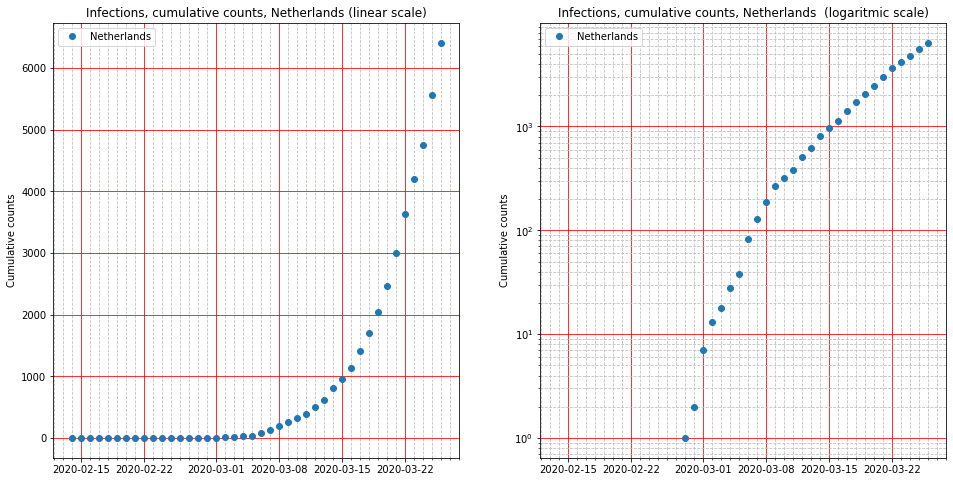

In [82]:
first_day = 45
country = 'Netherlands'
which_data = "cumsum_cases"

one_country = df.query("CountryExp == @country")[first_day:]
plt.figure(figsize=(16,8))

days = mdates.DayLocator()   # every year

## Linear scale
plt.subplot(121)
plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)
plt.title("Infections, cumulative counts, %s (linear scale)" %country)
plt.ylabel("Cumulative counts")
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
plt.legend()
ax = plt.gca()
ax.xaxis.set_minor_locator(days)
#plt.grid()

## Log scale
plt.subplot(122)
plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)
plt.title("Infections, cumulative counts, %s  (logaritmic scale)" %country)
plt.legend()
plt.yscale('log')
ax = plt.gca()
ax.xaxis.set_minor_locator(days)
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
plt.ylabel("Cumulative counts")


## Show data from table


In [0]:
one_country.head()

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId,Country Code,Pop_Data.2018,CountryExp,NewConfCases,NewDeaths,shifted_time,cumsum_cases,cumsum_deaths
4492,2020-02-14,14,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,45,0,0
4491,2020-02-15,15,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,46,0,0
4490,2020-02-16,16,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,47,0,0
4489,2020-02-17,17,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,48,0,0
4488,2020-02-18,18,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,49,0,0


## Comparing multiple countries 
In the following we plot the cumulative sum of cases for
*   The Netherlands
*   Italy
*   Belgium

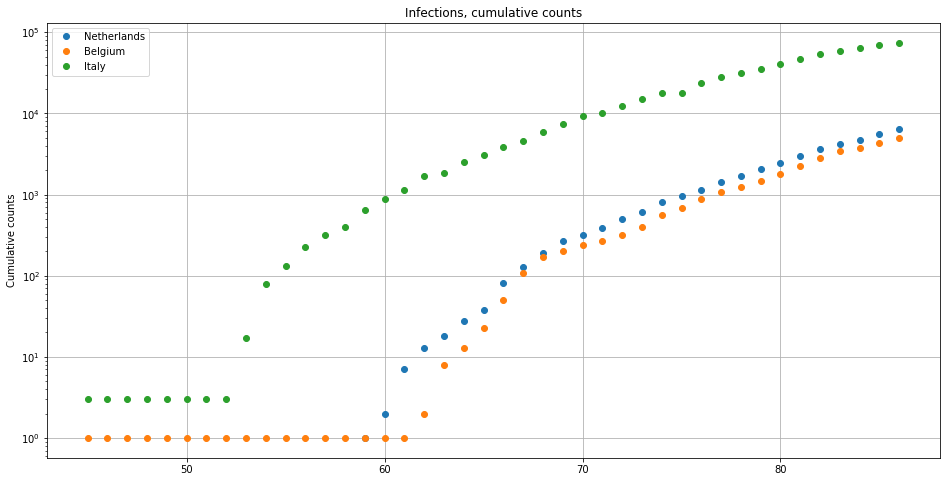

In [0]:
first_day = 45
countries = ['Netherlands','Belgium','Italy']
which_data = "cumsum_cases"
plt.figure(figsize=(16,8))

## plotting data from each country
for country in countries:
  one_country = df.query("CountryExp == @country")[first_day:]
  plt.plot(one_country.shifted_time, one_country["cumsum_cases"],"o",label=country)

plt.ylabel("Cumulative counts")
plt.legend()
plt.grid()
plt.title("Infections, cumulative counts")
plt.yscale('log')




## Data fitting with sigmoid function (logistic model)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


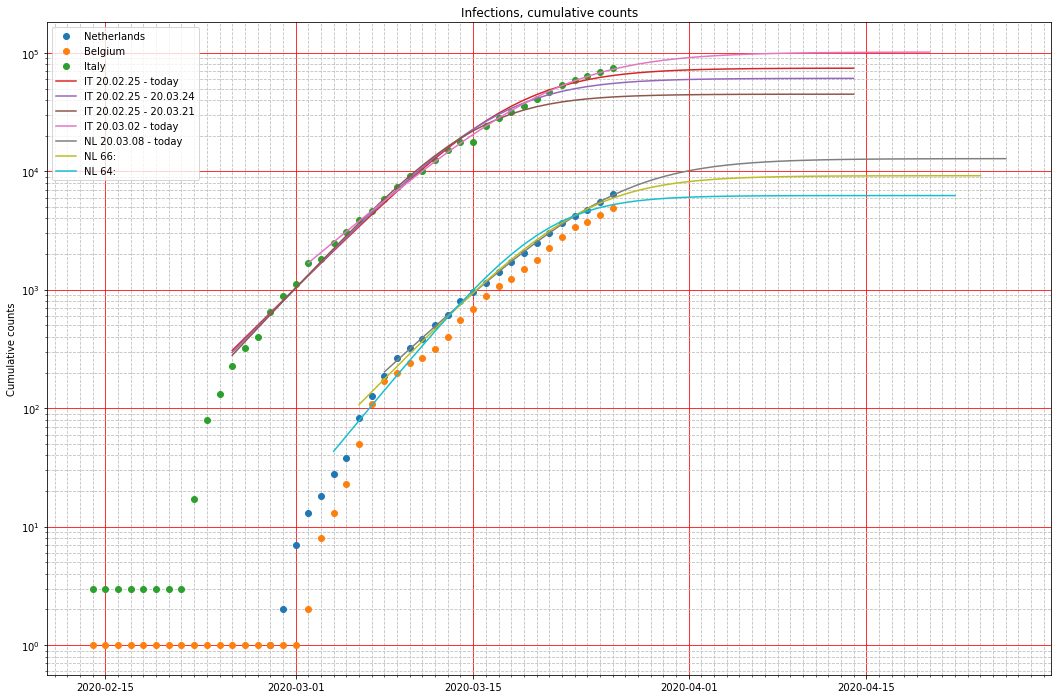

In [109]:
first_day = 45
fit_first_day_it = 56
fit_first_day_nl = 68

countries = ['Netherlands','Belgium','Italy']
which_data = "cumsum_cases"




plt.figure(figsize=(18,12))

for country in countries:
  one_country = df.query("CountryExp == @country")[first_day:]
  plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)

plt.ylabel("Cumulative counts")
plt.legend()
plt.grid()
plt.title("Infections, cumulative counts")
plt.yscale('log')

def flogistic(xx,p,k,r):  
  return p*k / (p + (p-k)*np.exp(-r*xx))

def logflogistic(xx,p,k,r):  
  return np.log(p*k / (p + (p-k)*np.exp(-r*xx)))

def fit_in_interval(one_country_ext,label='log-fit'):
  one_country = one_country_ext
  import scipy.optimize as opt

  ydata =  one_country.cumsum_cases
  integers_ = np.arange(len(one_country.cumsum_cases))

  popt_log, pcov_log = opt.curve_fit( flogistic, integers_ , ydata )

  log_popt_log, log_pcov_log = opt.curve_fit( logflogistic
                                            , integers_ 
                                            , np.log(ydata)
                                            , p0=popt_log)
  days_with_future_int = np.arange(50)  
  days_with_future = pd.Series([pd.Timedelta(days=x) for x in np.arange(50) ])
  
  plt.plot(days_with_future + one_country.DateRep.iloc[0] 
          , np.exp(logflogistic(days_with_future_int, *log_popt_log)), label=label )

it_time_columns = df.query("CountryExp == 'Italy'")[fit_first_day_it:].DateRep.dt.strftime("%y.%m.%d")
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:],label ='IT %s - today' % it_time_columns.iloc[0]) #,0,-1)
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][:-3],label='IT %s - %s' % (it_time_columns.iloc[0],it_time_columns.iloc[-3]) )
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][:-6],label='IT %s - %s' % (it_time_columns.iloc[0],it_time_columns.iloc[-6]))
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][6:],label='IT %s - today' % it_time_columns.iloc[6])


nl_time_columns = df.query("CountryExp == 'Netherlands'")[fit_first_day_nl:].DateRep.dt.strftime("%y.%m.%d")
fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl:],label='NL %s - today' % nl_time_columns.iloc[0])
fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl-2:],label='NL 66:')
fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl-4:],label='NL 64:')

plt.grid()
plt.grid(b=True, which='minor')#, color='r', linestyle='--')
plt.legend()
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
days = mdates.DayLocator()   # every year
ax = plt.gca()
ax.xaxis.set_minor_locator(days)

## Aligning time for different countries

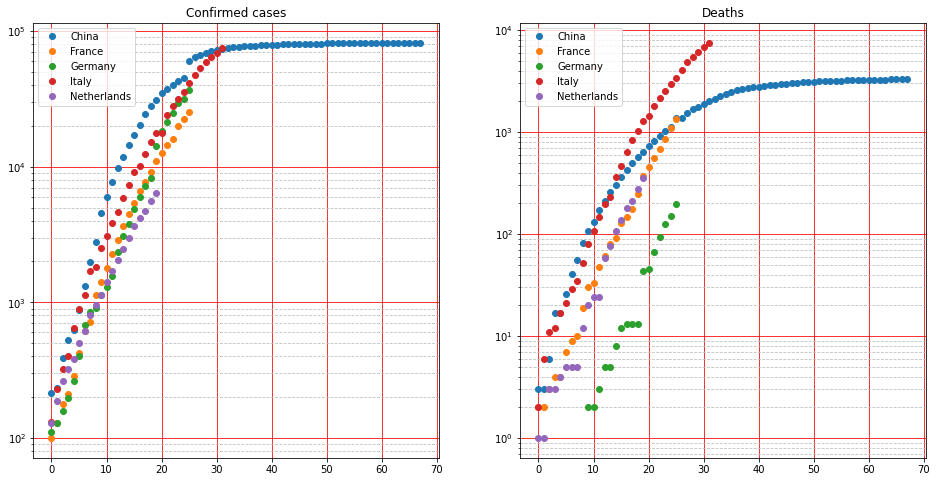

In [95]:
countries = ["Italy", "China", "Netherlands","Germany","France"]

plt.figure(figsize = (16,8))
plt.subplot(121)

#df.query('CountryExp in @countries').groupby('CountryExp').apply(lambda x : plt.plot(x.shifted_time,x.cumsum_cases)) #.cumsum_cases.plot()

for k,v in df_larger_10.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new,v.cumsum_cases,'o',label=k)
plt.title('Confirmed cases')
plt.yscale('log')
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.legend()

plt.subplot(122)
for k,v in df_larger_10.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new,v.cumsum_deaths,'o',label=k)

plt.title('Deaths')
plt.yscale('log')

ax = plt.gca()
#ax.xaxis.set_minor_locator(1)
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.legend()

## Aligning time for different countries, normalizing the counts vs. the population


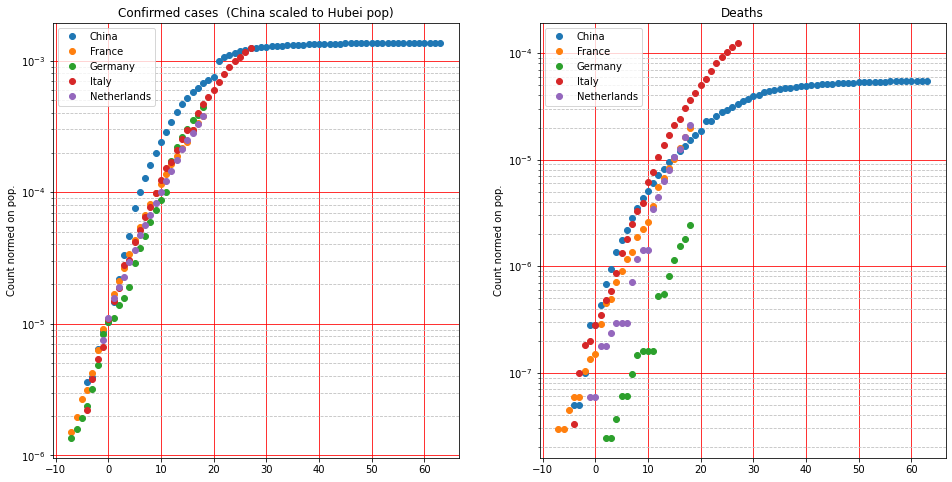

In [96]:
countries = ["Italy", "China", "Netherlands","Germany", "France"]
est_pop = [60e6,  60e6 ,17e6, 82e6,67e6 ]

pop_df = pd.DataFrame({"CountryExp": countries, "population" : est_pop})

df_loc = pd.merge(df_larger_10, pop_df, on='CountryExp')

df_loc['rel_cumsum_cases'] = df_loc.cumsum_cases/df_loc.population
df_loc['rel_cumsum_cases_st_1em5'] = df_loc['rel_cumsum_cases'] < 1e-5
df_loc['conf_rel_gt1em5'] =  df_loc.groupby('CountryExp').rel_cumsum_cases_st_1em5.transform('sum')


plt.figure(figsize = (16,8))
plt.subplot(121)

#df.query('CountryExp in @countries').groupby('CountryExp').apply(lambda x : plt.plot(x.shifted_time,x.cumsum_cases)) #.cumsum_cases.plot()

for k,v in df_loc.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new - v.conf_rel_gt1em5 ,v.cumsum_cases/v.population,'o',label=k)
plt.title('Confirmed cases  (China scaled to Hubei pop)')

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.ylabel('Count normed on pop.')
plt.yscale('log')
plt.legend()

plt.subplot(122)
for k,v in df_loc.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new - v.conf_rel_gt1em5,v.cumsum_deaths/v.population,'o',label=k)

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.title('Deaths')
plt.ylabel('Count normed on pop.')
plt.yscale('log')
plt.legend()

# Netherdelands data - from wikipedia

In [0]:
my_html_table = "https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Netherlands_medical_cases"

import pandas as pd
A = pd.read_html(my_html_table)

NL_situation = A[0][:-2]


def split_if_necessary(x):
  try:
    value = x.split('[')[0]
  except:
    value = x

  return value

NL_situation_cleaned = NL_situation.applymap(split_if_necessary)
NL_situation_cleaned.columns

MultiIndex([(         'Date[a]',   'Date[a]'),
            (        'Province',        'NB'),
            (        'Province',        'NH'),
            (        'Province',        'ZH'),
            (        'Province',        'DR'),
            (        'Province',        'UT'),
            (        'Province',        'GD'),
            (        'Province',        'FL'),
            (        'Province',        'OV'),
            (        'Province',        'LB'),
            (        'Province',        'ZL'),
            (        'Province',        'FR'),
            (        'Province',        'GR'),
            (        'Province',      'Unk.'),
            (        'Cases[b]',       'New'),
            (        'Cases[b]',     'Total'),
            (        'Cases[b]',     'Diff.'),
            ('Hospitalizations',     'Total'),
            ('Hospitalizations',       'ICU'),
            (          'Deaths',       'New'),
            (          'Deaths',     'Total'),
            (

## Data by province

In [0]:
NL_situation_cleaned['Province'].astype(float)

,NB,NH,ZH,DR,UT,GD,FL,OV,LB,ZL,FR,GR,Unk.
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.0,4.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7.0,2.0,5.0,1.0,20.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,4.0
8,10.0,1.0,10.0,NaN,10.0,8.0,1.0,NaN,7.0,NaN,NaN,NaN,-1.0
9,26.0,7.0,7.0,NaN,14.0,3.0,NaN,3.0,2.0,1.0,NaN,NaN,-3.0


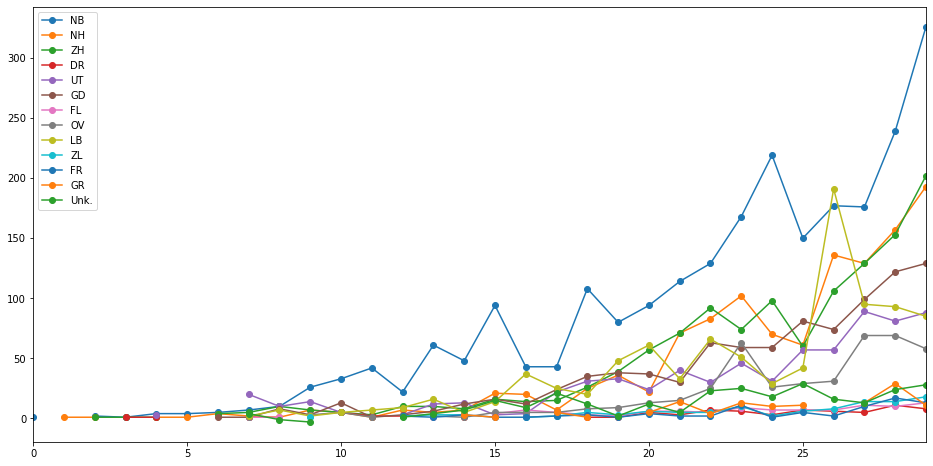

In [0]:
plt.figure(figsize=(16,8))
ax = plt.gca()
NL_situation_cleaned['Province'].astype(float).plot(marker='o',ax = ax)